In [1]:
import ujson
import numpy 
import datetime
from collections import Counter, defaultdict

from features import *
import features
reload(features)
import sys, os
sys.path.append(os.getcwd())

from filter_data import user_project_filter, print_datastats

## 1. Load Data

In [2]:
# loads pre-computed counts of each active block type per project for every user 
blockcounts = ujson.load(open('user_project_allblockcounts.json'))
# loads other stats 
othercounts = ujson.load(open('user_project_othercounts.json'))

print_datastats(blockcounts)

46320 users and 1546033 projects


## 2. Get Language Labels

The languages labels are inferred from the `namestrings_to_langs.py` script using `langid`.

In [3]:
isocodes = ujson.load(open('isocodes.json'))  # mapping from  iso code to language name
user_langs = ujson.load(open('user_inferredlangs.json'))  # mapping from userid to inferred language
# remove uncommon languages
lang_counts = Counter()
for user in user_langs:
    lang = user_langs[user]
    lang_counts[lang] += 1
    
user_langs = {user: lang for user, lang in user_langs.items() if lang_counts[lang]>=250 and user in blockcounts}
langset = set(user_langs.values())
print 'lang data created with', len(user_langs), 'users and', len(langset), 'languages', langset

# filter these users from code summaries
blockcounts = {user: blockcounts[user] for user in user_langs}
othercounts = {user: othercounts[user] for user in user_langs}

lang data created with 43160 users and 11 languages set([u'el', u'fr', u'en', u'zh', u'pt', u'ca', u'de', u'ko', u'it', u'th', u'es'])


Create a map from each language to the set of users assigned to that language.

In [4]:
lang_users = defaultdict(set)  
for user in user_langs:
    lang = user_langs[user]
    lang_users[lang].add(user)
print sorted([(len(lang_users[lang]), lang) for lang in lang_users])

[(257, u'th'), (291, u'el'), (322, u'fr'), (451, u'de'), (470, u'ca'), (838, u'pt'), (862, u'it'), (3605, u'ko'), (4926, u'es'), (9950, u'zh'), (21188, u'en')]


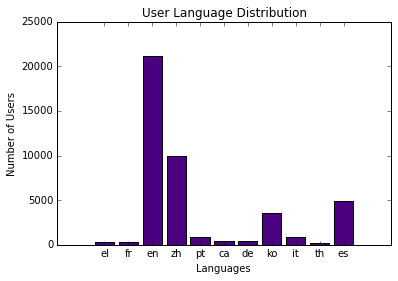

In [5]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def plot_langs(lang_users):
    y_pos = np.arange(len(lang_users))
    plt.bar(y_pos, [len(lang_users[lang]) for lang in lang_users], color = 'indigo', align='center')
    plt.xticks(y_pos, lang_users.keys())
    plt.ylabel('Number of Users')
    plt.xlabel('Languages')
    plt.title('User Language Distribution')
    #plt.savefig('langdist.png')
    plt.show()
    
plot_langs(lang_users)

## 2. Filter Unoriginal Projects

Remove tutorials. Run the cells below only if we want to filter.

In [6]:
nontutorials = ujson.load(open('user_nontutorial_projects.json'))
blockcounts = user_project_filter(blockcounts, nontutorials)
othercounts = user_project_filter(othercounts, nontutorials)
print_datastats(blockcounts)

43075 users and 907797 projects


Filter projects that are identical to several projects from many users (results of `identify_similar.py` and `process_graph.py`).

In [7]:
hypnontutorials = ujson.load(open('user_hypnontutorial_projects.json'))
blockcounts = user_project_filter(blockcounts, hypnontutorials)
othercounts = user_project_filter(othercounts, hypnontutorials)
print_datastats(blockcounts)

40648 users and 271113 projects


Finally, discard any users with fewer than 5 projects after the above filtering steps.

7848 users and 122139 projects


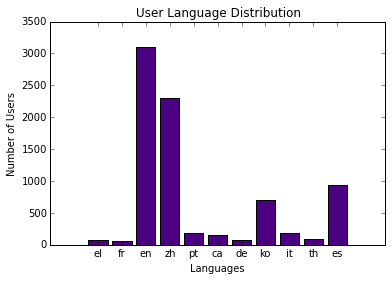

In [8]:
blockcounts = {user: blockcounts[user] for user in blockcounts if len(blockcounts[user])>=10}
othercounts = {user: othercounts[user] for user in othercounts if len(othercounts[user])>=10}
print_datastats(blockcounts)

filtered_lang_users = {}
for lang in lang_users:
    filtered_lang_users[lang] = lang_users[lang].intersection(blockcounts)
plot_langs(filtered_lang_users)

## 2. Featurize (Code)

In [15]:
import code_features
reload(code_features)

def combine_featfuncs(funclist):
    def combined(user):
        basedict = funclist[0](user)
        for f in funclist[1:]:
            basedict.update(f(user))
        return basedict
    return combined

In [10]:
langgroups = {'es': 'eur',
              'pt': 'eur', 
              'it': 'eur', 
              'de': 'eur', 
              'fr': 'eur', 
              'ca': 'eur', 
              'el': 'eur', 
              'nl': 'eur', 
              'pl': 'eur',
              'en': 'eur',
              'ko': 'asia', 
              'zh': 'asia', 
              'th': 'asia'}
user_lang_groups = {user: langgroups[lang] for user, lang in user_langs.items() if lang in langgroups.keys()}

In [16]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import LabelEncoder 

GROUPLANG = True
labels = []
featurized = []
for user in blockcounts:
    if GROUPLANG:
        labels.append(user_lang_groups[user])  # eur/asian
    else:
        labels.append(user_langs[user])  # uncollapsed languages

    featurized.append(code_features.get_all_blocks(blockcounts[user]))
    
le = LabelEncoder()
y = le.fit_transform(labels)

codevec = DictVectorizer()
Xcode = codevec.fit_transform(featurized)

from sklearn.preprocessing import scale
# convert to dense matrices since these are dense anyway
Xcode = scale(Xcode.toarray())

In [17]:
print Xcode.shape

(7848, 1022)


#### Static KFold Values

In [18]:
import pickle
import os
from sklearn.cross_validation import StratifiedKFold

foldfile = 'final_filtered_indices.pickle'
if os.path.isfile(foldfile):
    foldindices = pickle.load(open(foldfile))
else:
    foldindices = StratifiedKFold(y)
    with open(foldfile, 'w') as o:
        pickle.dump(foldindices, o)

/usr/local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Model Training and Testing

Chance is 0.606141692151
Building a logreg_l1 model with 1022 features
Fold 1
Fold 2
Fold 3
Average accuracy: 0.867481173934


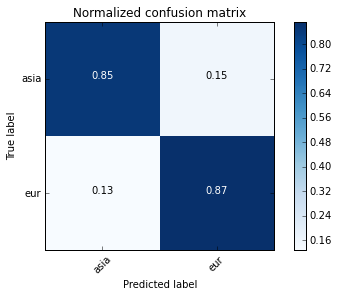

[(3.038377568981391, u'Texting.SetReceivingEnabled'), (2.1324843730508842, u'ImageSprite.EdgeReached'), (1.7010507841896392, u'ContactPicker.GetEmailAddress'), (1.6107488400516889, u'TinyDB.StoreValue'), (1.5584757320072973, u'Web.SetUrl'), (1.5409581456873989, u'BluetoothClient.ReceiveSigned2ByteNumber'), (1.4804034614220052, u'ActivityStarter.ResolveActivity'), (1.4525153137086462, u'TextBox.LostFocus'), (1.3668771459327029, u'Form.SetAlignVertical'), (1.2654309563220576, u'ListView.GetVisible'), (1.2166710994429564, u'BluetoothClient.GetEnabled'), (1.1754651285959701, u'procedures_defnoreturn'), (1.1695595792414666, u'TinyDB.GetValue'), (1.1564041265238605, u'TextToSpeech.Speak'), (1.0792208918469253, u'PasswordTextBox.SetVisible'), (1.0517484310657133, u'LocationSensor.GetDistanceInterval'), (1.0126265988298444, u'Clock.Now'), (0.99733221887001766, u'WebViewer.GetVisible'), (0.9747499216457165, u'LocationSensor.GetCurrentAddress'), (0.9268376130387912, u'WebViewer.GetHomeUrl'), (0.

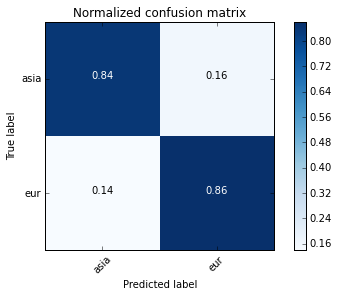

[(1.9585425203195495, u'Texting.SetReceivingEnabled'), (1.8889984833046234, u'ImageSprite.EdgeReached'), (1.5567603799163359, u'ContactPicker.GetEmailAddress'), (1.4898386857166512, u'TinyDB.StoreValue'), (1.471080439145247, u'TextBox.LostFocus'), (1.4427064320667757, u'BluetoothClient.ReceiveSigned2ByteNumber'), (1.3993525318308697, u'TinyDB.GetValue'), (1.3623718643583431, u'Form.SetAlignVertical'), (1.3064732867603537, u'procedures_defnoreturn'), (1.2765195006803458, u'ActivityStarter.ResolveActivity'), (1.2623806139846399, u'BluetoothClient.GetEnabled'), (1.1722580034863783, u'Web.SetUrl'), (1.1356355919818315, u'Clock.Now'), (1.0907494290539292, u'ListView.GetVisible'), (1.0600912849416859, u'WebViewer.GetHomeUrl'), (1.0513184869924843, u'WebViewer.GetVisible'), (1.0205628882551938, u'TextToSpeech.Speak'), (1.0181069797318658, u'BluetoothServer.AcceptConnection'), (0.99620074460787911, u'FusiontablesControl.GetRowsWithConditions'), (0.99328670858042756, u'LocationSensor.GetCurrent

In [22]:
from sklearn.neighbors import KNeighborsClassifier
from  sklearn.metrics import f1_score 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline 
import plotcnf
reload(plotcnf)
from sklearn.decomposition import PCA

print 'Chance is', max(numpy.bincount(y))/float(len(y))

classifiers = [('logreg_l1', LogisticRegression(penalty = 'l1', class_weight='balanced')),
              ('logreg_l2', LogisticRegression(penalty = 'l2', class_weight='balanced'))]     

for modelname, model in classifiers:
    for featname, X in [('code', Xcode)]:
        print  'Building a', modelname, 'model with', X.shape[1], 'features'
    
        cvaccs = numpy.zeros(len(foldindices))
        #cvf1 = numpy.zeros(len(foldindices))
        for i, (trainidx, testidx) in enumerate(foldindices):
            
            print 'Fold', i+1
        
            ytrain = y[trainidx]
            ytest = y[testidx]
        
            Xtrain = X[trainidx, :]  
            Xtest = X[testidx, :]
            
            model.fit(Xtrain, ytrain)
            cvaccs[i] = model.score(Xtest, ytest)
            
            predictions = model.predict(Xtest)

        print 'Average accuracy:', numpy.mean(cvaccs)
        #analyze last fold only
        cnf_matrix = confusion_matrix(ytest, predictions)  
        plotcnf.plot_confusion_matrix(cnf_matrix, le.classes_, normed=True)
        plt.show()
        #importances = sorted(filter(lambda x:x[0]!=0, zip(model.coef_[0], codevec.feature_names_)), reverse=True)
        #print importances
        